## Part 1 ‑ Exploratory data analysis
The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15­minute time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them

In [93]:
# import necessary packages
import pandas as pd
import os
import matplotlib.pyplot as plt

In [94]:
os.chdir('C:\Springboard\Github\Ch26_2_Take_home')

In [95]:
# import the JSON file first
df = pd.read_json('logins.json')
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


That's weird to see a log of logins in 1970. I would be more concerned that this data had the appropriate timestamps.

In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


That's excellent to see that the column was interpretted as datetime

In [97]:
df.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


This is great to see the range that we are working with from January 1st at 8pm to April 13th at 7pm of 1970. <br>
<br>
In order to resample this data, I need to make the timestamp the index, so I will add a column of ones to indicate a single login and then resample based on the timestamp index. 

In [98]:
# add column of ones so that we can sum once we aggregate by time
df['logs'] = 1

In [99]:
# sets the index to the login_time so that we can aggregate by those values
df = df.set_index('login_time')
df.head()

,logs
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


In [100]:
# let's aggregate by 15-min intervals
dfa = df.resample('15T').sum()
dfa

,logs
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1
...,...
1970-04-13 17:45:00,5
1970-04-13 18:00:00,5
1970-04-13 18:15:00,2


That looks much better. Let's plot those login values to see how they look.

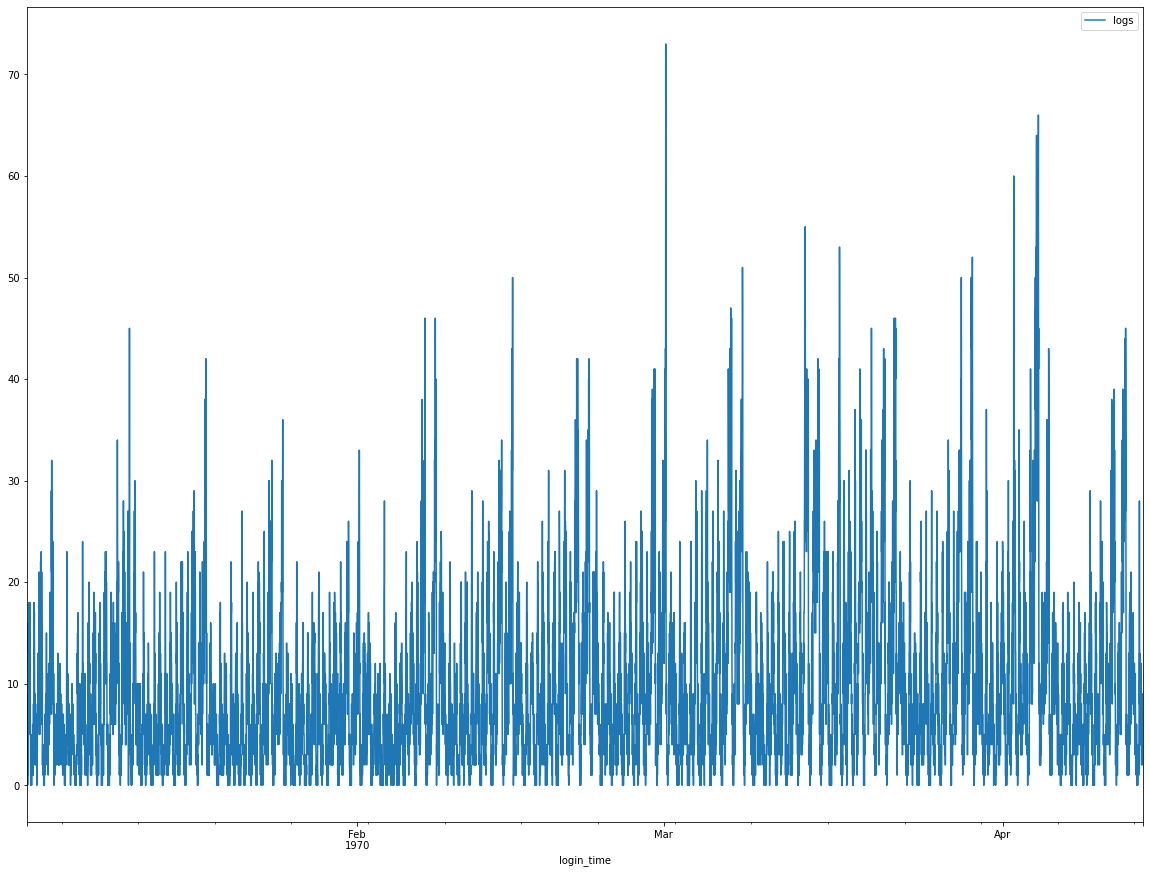

In [101]:
_ = dfa.plot(figsize=(20,15))
# xlabel
# ylabel
# remove legend?

In [102]:
# let's look at the stats
dfa.describe()

,logs
count,9788.000000
mean,9.515938
std,8.328818
min,0.000000
25%,3.000000
50%,7.000000
75%,13.000000
max,73.000000


There appears to be some trends in this time series. There maybe some anomolies in that data set. Let's look at the box and whiskers.

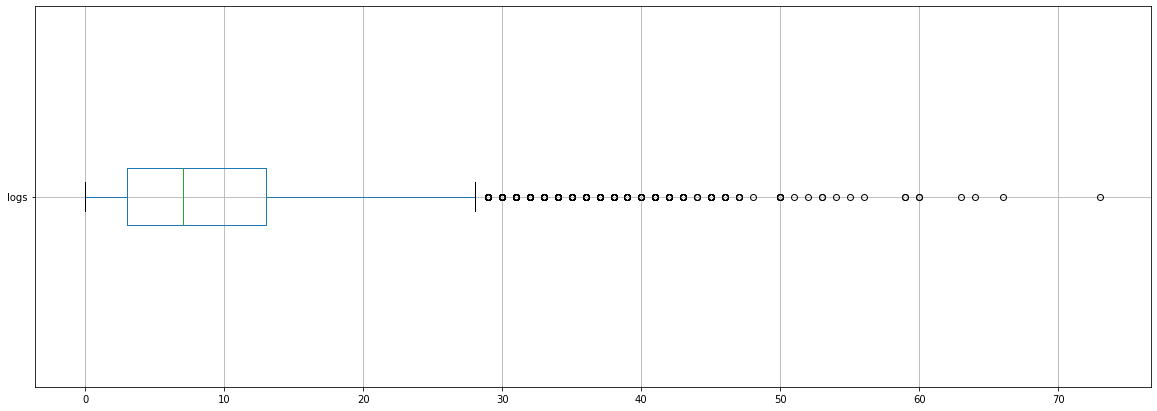

In [103]:
# box and whiskers
_ = dfa.boxplot(figsize=(20,7), vert=False)

Looks like there are some outliers in that data set. Let's identify those before going any further.

In [104]:
# calculate average and standard deviation for the outliers
Q1 = dfa['logs'].quantile(q=0.25)
Q3 = dfa['logs'].quantile(q=0.75)
# compute the cutoff for the outlier on the upper end (there is no lower outliers)
out = Q3 + 1.5*(Q3 - Q1)

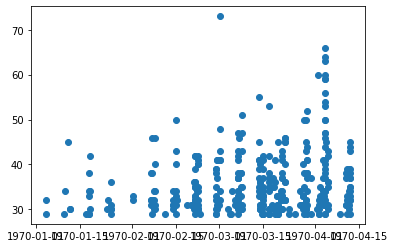

In [105]:
# find out where those outlier are in the data set
outliers = dfa[dfa['logs'] > out]
outliers
plt.scatter(x=outliers.index, y=outliers['logs']) #figsize=(15,10)

 To decompose this better, I will use FB's Prophet

In [106]:
# let's take a better look at this with FB's Prophet
from fbprophet import Prophet

dfo = dfa.copy()
# rename the columns according to Prophet convention
dfa['ds'] =dfa.index
dfa.rename(columns={"logs":"y"}, inplace=True)
dfa.head()

,y,ds
login_time,,
1970-01-01 20:00:00,2,1970-01-01 20:00:00
1970-01-01 20:15:00,6,1970-01-01 20:15:00
1970-01-01 20:30:00,9,1970-01-01 20:30:00
1970-01-01 20:45:00,7,1970-01-01 20:45:00
1970-01-01 21:00:00,1,1970-01-01 21:00:00


In [107]:
dfa.columns

Index(['y', 'ds'], dtype='object')

In [108]:
# creates Prophet model
m_fb = Prophet(yearly_seasonality = False, daily_seasonality=True, weekly_seasonality=True)
m_fb.add_country_holidays(country_name='US')
m_fb.fit(dfa)

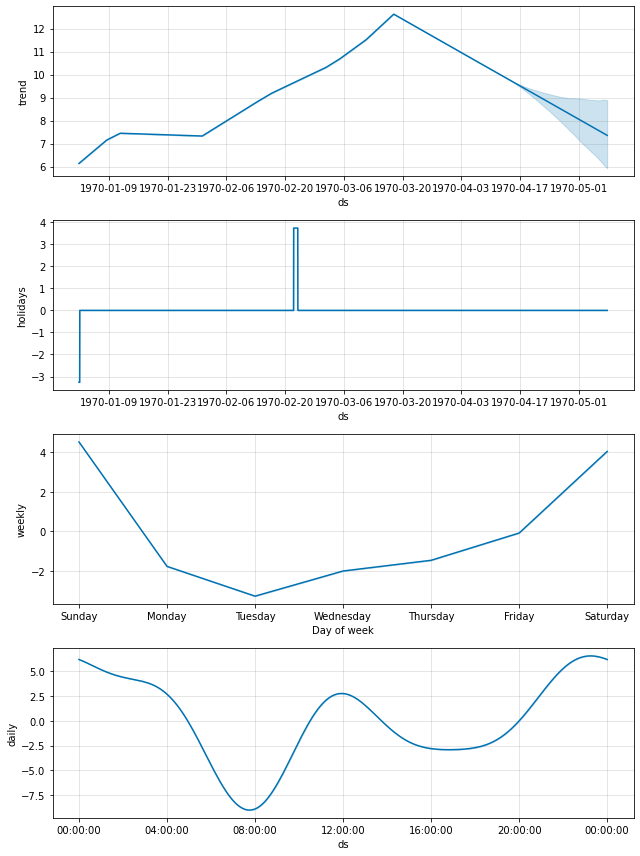

In [109]:
# plot Prophet Results
future = m_fb.make_future_dataframe(periods=24)
forecast = m_fb.predict(future)
_ = m_fb.plot_components(forecast)

Here are some observations from the data:
- There is a clear upward trend around March 1st and then dropping off afterward
- Logins appear far more significant on weekends
- The time zone maybe incorrect, as I would expect logins to not be minimum just before 8am but rather more like 5am
- The year is probably incorrect in the data, as logging into anything in 1970 was uncommon

Before I am done, I want to drop the outliers and run FB Prophet again to see if anything is different

In [110]:
dfo

,logs
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1
...,...
1970-04-13 17:45:00,5
1970-04-13 18:00:00,5
1970-04-13 18:15:00,2


In [111]:
dfo = dfo[~dfo.index.isin(outliers.index)]
dfo

,logs
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1
...,...
1970-04-13 17:45:00,5
1970-04-13 18:00:00,5
1970-04-13 18:15:00,2


In [112]:
# rename columns and run Prophet again
# rename the columns according to Prophet convention
dfo['ds'] = dfo.index
dfo.rename(columns={"logs":"y"}, inplace=True)
dfo.head()

C:\Users\sjrek\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\sjrek\anaconda3\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,y,ds
login_time,,
1970-01-01 20:00:00,2,1970-01-01 20:00:00
1970-01-01 20:15:00,6,1970-01-01 20:15:00
1970-01-01 20:30:00,9,1970-01-01 20:30:00
1970-01-01 20:45:00,7,1970-01-01 20:45:00
1970-01-01 21:00:00,1,1970-01-01 21:00:00


In [113]:
# let's try the prophet model again
# creates Prophet model
m = Prophet(yearly_seasonality = False, daily_seasonality=True, weekly_seasonality=True)
m.fit(dfo)

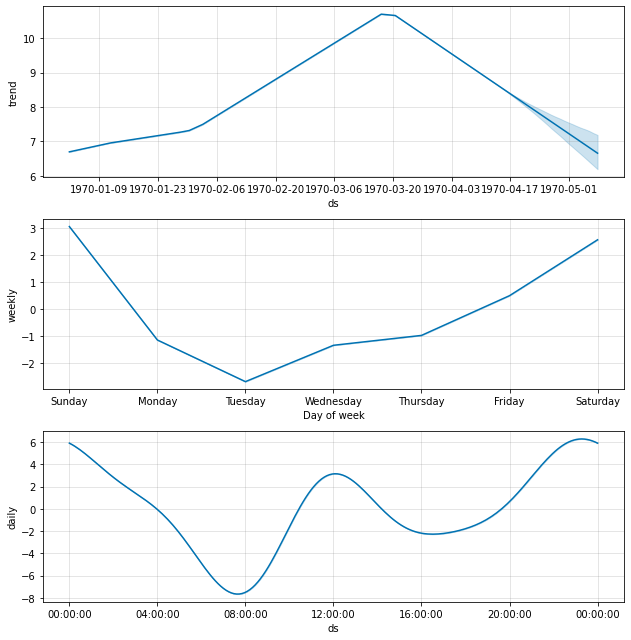

In [114]:
# plot Prophet Results
future = m.make_future_dataframe(periods=24)
forecast = m.predict(future)
_ = m.plot_components(forecast)

These results look very similar to the model that included the outliers, but the peaks are tamed a bit on the trend and weekley components, but the daily difference look more pronounced.